# <center>Practical Lab 10 - Fine-Tune VGG16 for Bird Classification</center>

### Name: Devarsh Shah
### ID: 8917026
---

In [1]:
# Importing necessary packages
import os
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, precision_recall_curve, auc
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize


# 1. Obtain the Data
- Download the BIRDS 525 SPECIES dataset from Kaggle (CC0 license). You will need to create a free Kaggle account, and this will provide you free access to many such datasets, as well as code and even online notebooks.
- Unpack the data. Notice that the data is organized into folders in a way similar to the Dogs vs Cats dataset that we worked with. This makes it easy to load with the same Keras function (ImageDataGenerator.flow_from_directory).

In [3]:
# Loading the dataset
birds_train = "D:/conestoga-aiml/Semester1/foundationML/archive_unpack/train"
birds_test = "D:/conestoga-aiml/Semester1/foundationML/archive_unpack/test"
birds_valid = "D:/conestoga-aiml/Semester1/foundationML/archive_unpack/valid"

- For this lab, we will work with the 3 classes with the highest number of images. Identify those classes, and use only these for the next steps.

In [5]:
# keeping count of images
image_count = {}

# Function to count images in a directory
def count_images(directory_path):
    return sum(1 for file in os.scandir(directory_path) if file.is_file())

# Function to count number of images in each sub-directory within a directory
def count_images_per_class(parent_directory):
    for entry in os.scandir(parent_directory):
        if entry.is_dir():
            image_count[entry.name] = count_images(entry.path)


# Finding image counts for each class in the bird_train folder
count_images_per_class(birds_train)

# Sorting in descending order
sorted_image_count = sorted(image_count.items(), key=lambda item: item[1], reverse=True)

# Get the top 3 classes
top_3_classes = [class_name for class_name, count in sorted_image_count[:3]]

# Print top 3 classes
print("Top 3 Classes:", top_3_classes)


Top 3 Classes: ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


- You can delete/discard the others.

In [6]:
# Deleting other directories from birds_train, birds_test and birds_valid folder
for birds_species in os.listdir(birds_train):
    if birds_species not in top_3_classes:
        delete_path_train = os.path.join(birds_train, birds_species)
        shutil.rmtree(delete_path_train)

for birds_species in os.listdir(birds_test):
    if birds_species not in top_3_classes:
        delete_path_test = os.path.join(birds_test, birds_species)
        shutil.rmtree(delete_path_test)

for birds_species in os.listdir(birds_valid):
    if birds_species not in top_3_classes:
        delete_path_valid = os.path.join(birds_valid, birds_species)
        shutil.rmtree(delete_path_valid)

## 2. Use data-augmentation to increase the number of training images. You are encouraged to try out various augmentation methods supported by Keras. The rule of thumb is that as long as an augmentation produces realistic images - it is probably a good idea to add it.(2 point)

In [7]:
# Setting up the training dataset
birds_train_dataset = image_dataset_from_directory(
    birds_train,
    image_size=(180, 180),
    batch_size=32)

# Setting up the testing dataset
birds_test_dataset = image_dataset_from_directory(
    birds_test,
    image_size=(180, 180),
    batch_size=32)

# Setting up the validation dataset
birds_valid_dataset = image_dataset_from_directory(
    birds_valid,
    image_size=(180, 180),
    batch_size=32)


Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


## `Augmenting Data`

In [8]:
# Create data generators with augmented settings
data_augmentation = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.3,          
    zoom_range=0.3,           
    horizontal_flip=True,
    fill_mode='nearest'
)

# Set up training data generator
train_generator = data_augmentation.flow_from_directory(
    birds_train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Set up testing data generator
test_generator = data_augmentation.flow_from_directory(
    birds_test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Set up validation data generator
validation_generator = data_augmentation.flow_from_directory(
    birds_valid,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


### `Plotting the Augmented Images`

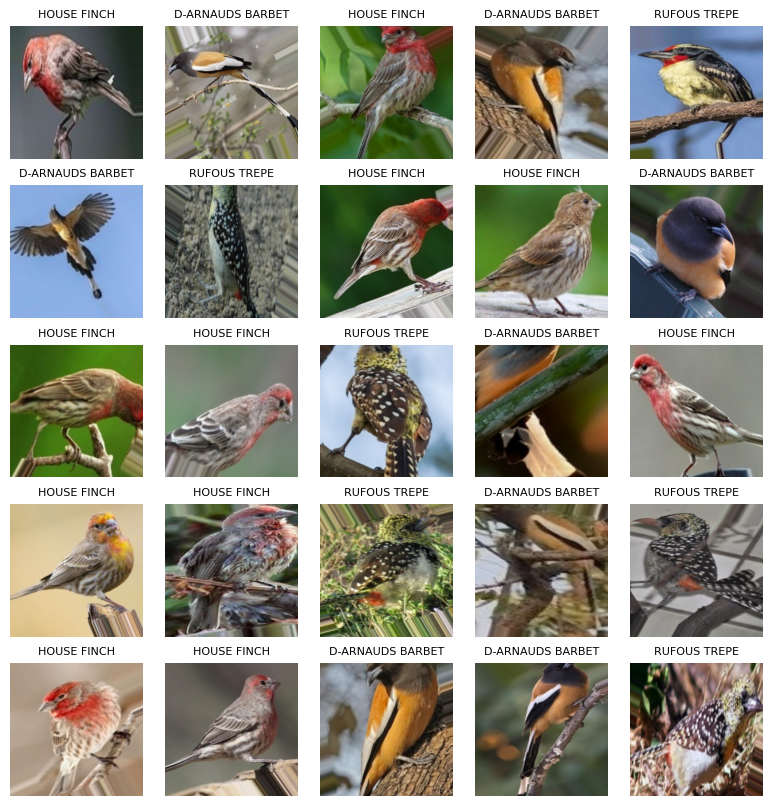

In [10]:

birds_img_labels = {0: 'RUFOUS TREPE', 1: 'HOUSE FINCH', 2: 'D-ARNAUDS BARBET'}

def display_augmented_images(generator, num_images=25, grid_dim=(5, 5)):
    plt.figure(figsize=(10, 10))
    images, labels = generator.next()

    for i in range(num_images):
        ax = plt.subplot(grid_dim[0], grid_dim[1], i + 1)
        ax.imshow(images[i].astype('uint8'))
        decoded_label = birds_img_labels[np.argmax(labels[i])]
        ax.set_title(decoded_label, fontsize=8)
        ax.axis("off")

    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.show()

display_augmented_images(train_generator)


### 3. Fine-Tune VGG16 (pre-trained on imagenet), to classify the 3 classes (2 points)

In [11]:
# Getting VGG16 model with imagenet weights
VGG16_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

VGG16_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                              

In [12]:
# this function preprocesses the images as features and labels.
def get_birds_features_and_labels(dataset):
    birds_all_features = []
    birds_all_labels = []

    # Creating a for loop over the dataset and extract the features and labels
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = VGG16_model.predict(preprocessed_images)
        birds_all_features.append(features)
        birds_all_labels.append(labels)

    return np.concatenate(birds_all_features), np.concatenate(birds_all_labels)

train_features, train_labels = get_birds_features_and_labels(birds_train_dataset)
test_features, test_labels = get_birds_features_and_labels(birds_test_dataset)
val_features, val_labels = get_birds_features_and_labels(birds_valid_dataset)


1/1 [==============================] - 2s 2s/step


In [13]:
# Freeze the layers of the pre-trained VGG16 model
for layer in VGG16_model.layers:
    layer.trainable = False

# Create a custom model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = VGG16_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation='softmax')(x)
custom_model = tf.keras.Model(inputs, outputs)

# Display the summary of the custom model
custom_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                             

In [14]:
# Compiling the custom_model with the Adam optimizer, categorical crossentropy loss, and accuracy metric.
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model using fit() method with the train_generator as the training data.
validation_data_run = custom_model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
24/24 [==============================] - 165s 7s/step - loss: 1.5882 - accuracy: 0.7970 - val_loss: 2.7736e-06 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 166s 7s/step - loss: 0.2333 - accuracy: 0.9556 - val_loss: 0.0710 - val_accuracy: 0.9333
Epoch 3/10
24/24 [==============================] - 183s 8s/step - loss: 0.1694 - accuracy: 0.9718 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 189s 8s/step - loss: 0.2179 - accuracy: 0.9516 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 153s 6s/step - loss: 0.1695 - accuracy: 0.9691 - val_loss: 7.5338e-04 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 155s 6s/step - loss: 0.0955 - accuracy: 0.9772 - val_loss: 0.3977 - val_accuracy: 0.8667
Epoch 7/10
24/24 [==============================] - 165s 7s/step - loss: 0.0946 - accuracy: 0.9825 - val_loss: 4.2835e-06 - val_accuracy: 1.0000
E

#### 4. Explore the model performance: accuracy, confusion metric, precision, recall, F1-score, precision-recall curve and its area under the curve (AUC). Explore specific examples in which the model failed to predict correctly. (2 points)

In [15]:
model_accuracy = validation_data_run.history["accuracy"]
model_validation_accuracy = validation_data_run.history["val_accuracy"]
model_loss = validation_data_run.history["loss"]
model_validation_loss = validation_data_run.history["val_loss"]
epochs = range(1, len(model_accuracy) + 1)

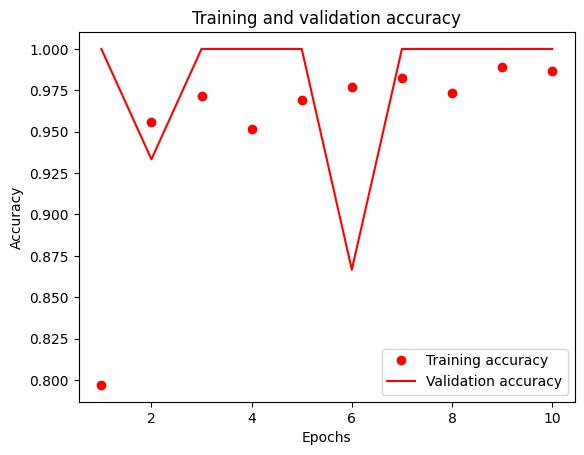

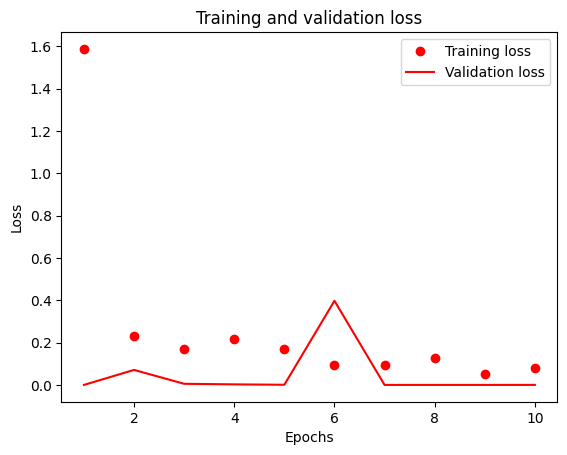

In [17]:
plt.plot(epochs, model_accuracy, "ro", label="Training accuracy")
plt.plot(epochs, model_validation_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(epochs, model_loss, "ro", label="Training loss")
plt.plot(epochs, model_validation_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
model_validation_loss, validation_model_acc = custom_model.evaluate(validation_generator)
print(f'Model validation accuracy: {validation_model_acc}')
print(f'Model validation loss: {model_validation_loss}')

1/1 [==============================] - 4s 4s/step - loss: 3.9448e-04 - accuracy: 1.0000
Model validation accuracy: 1.0
Model validation loss: 0.00039447660674341023


In [23]:
# Calculating accuracy, confusion matrix, precision, recall, F1-score

test_predictions = custom_model.predict(test_generator)
test_predictions_classes = np.argmax(test_predictions, axis=1)

accuracy = accuracy_score(test_labels, test_predictions_classes)
precision = precision_score(test_labels, 
test_predictions_classes, average='macro')
recall = recall_score(test_labels, test_predictions_classes, average='macro')
f1 = f1_score(test_labels, test_predictions_classes, average='macro')

cm = confusion_matrix(test_labels, test_predictions_classes)

print(f"Test Accuracy: {round(accuracy,4)}")
print(f"Confusion Matrix:\n {cm}")
print(f"Precision: {round(precision,4)}")
print(f"Recall: {round(recall,4)}")
print(f"F1 score: {round(f1,4)}")

class_report = classification_report(test_labels, test_predictions_classes, target_names = birds_img_labels.values())

print(f"Classification Report:\n {class_report}")

1/1 [==============================] - 4s 4s/step
Test Accuracy: 0.4
Confusion Matrix:
 [[1 2 2]
 [1 3 1]
 [3 0 2]]
Precision: 0.4
Recall: 0.4
F1 score: 0.4
Classification Report:
                   precision    recall  f1-score   support

    RUFOUS TREPE       0.20      0.20      0.20         5
     HOUSE FINCH       0.60      0.60      0.60         5
D-ARNAUDS BARBET       0.40      0.40      0.40         5

        accuracy                           0.40        15
       macro avg       0.40      0.40      0.40        15
    weighted avg       0.40      0.40      0.40        15



-  Precision-recall curve and its area under the curve (AUC) 

AUC of D-ARNAUDS BARBET: 0.2421
AUC of HOUSE FINCH: 0.5864
AUC of RUFOUS TREPE: 0.5351


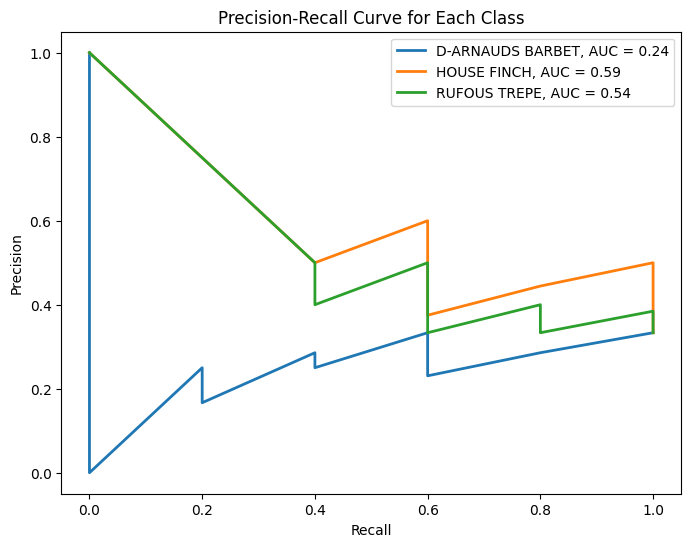

In [25]:
# Converting categorical values to one-hot encoding
y_true_one_hot = label_binarize(test_labels, classes=[0, 1, 2])
class_names = {v: k for k, v in validation_generator.class_indices.items()}

# Calculating precision-recall curve
plt.figure(figsize=(8, 6))
for i in range(3):
    # Getting the precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], test_predictions[:, i])
    
    # Calculating the area under the curve
    auc_score = auc(recall, precision)
    class_name = class_names[i]
    
    print(f'AUC of {class_name}: {round(auc_score, 4)}')
    
    # Plotting the precision-recall curve
    plt.plot(recall, precision, lw=2, label='{}, AUC = {:.2f}'.format(class_name, auc_score))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve for Each Class')
plt.show()


- Model failure prediction

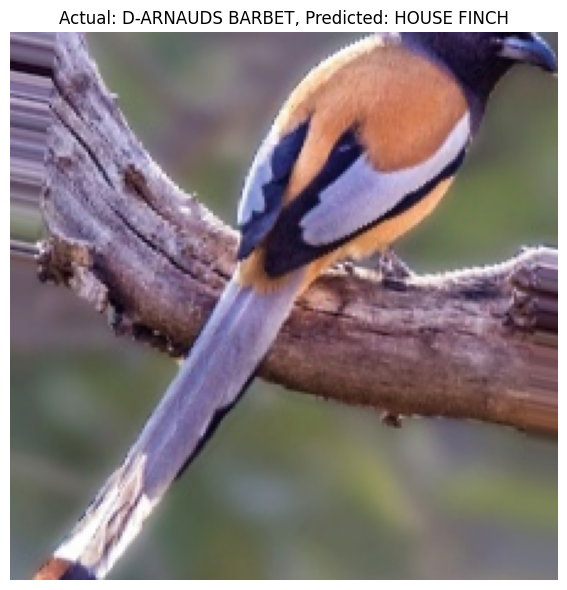

Predicted Probabilities:
D-ARNAUDS BARBET: 0.0000
HOUSE FINCH: 1.0000
RUFOUS TREPE: 0.0000


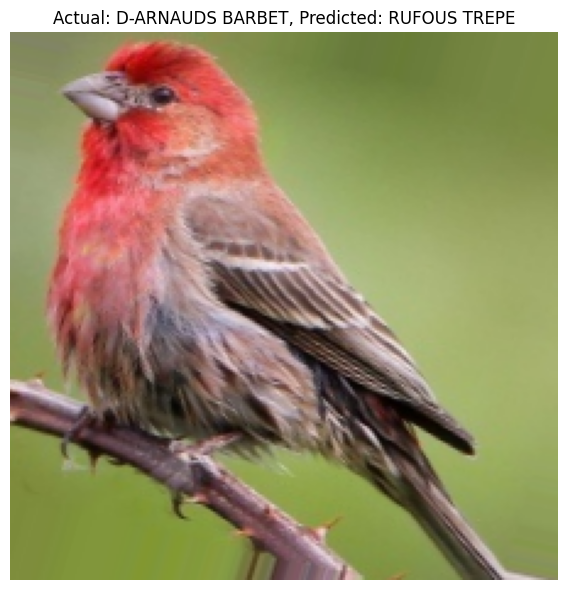

Predicted Probabilities:
D-ARNAUDS BARBET: 0.0000
HOUSE FINCH: 0.0000
RUFOUS TREPE: 1.0000


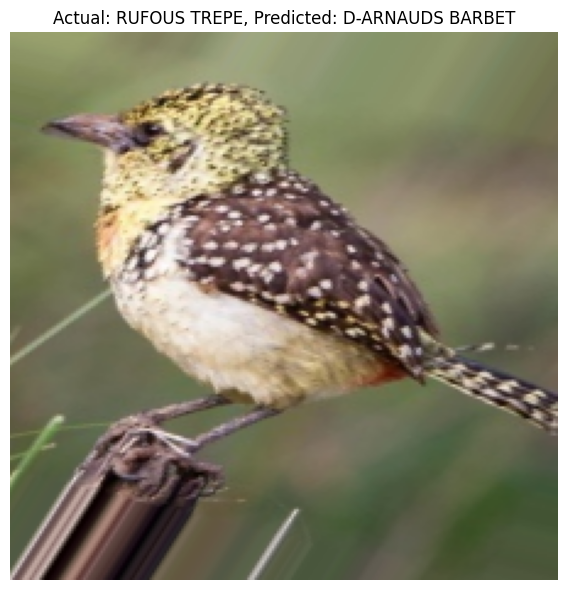

Predicted Probabilities:
D-ARNAUDS BARBET: 1.0000
HOUSE FINCH: 0.0000
RUFOUS TREPE: 0.0000


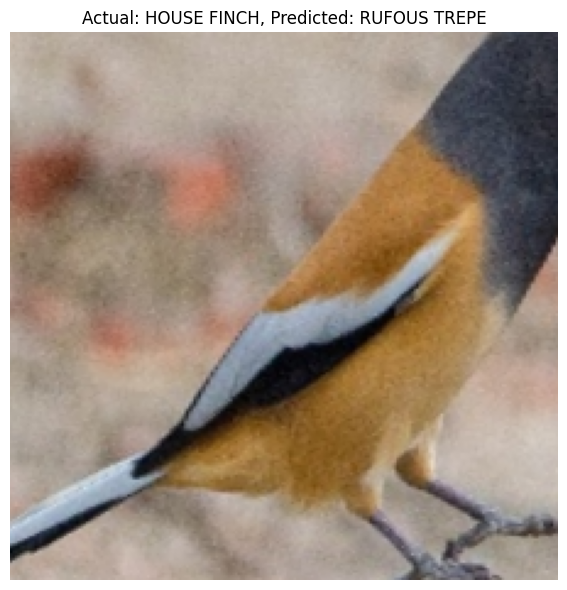

Predicted Probabilities:
D-ARNAUDS BARBET: 0.0000
HOUSE FINCH: 0.0000
RUFOUS TREPE: 1.0000


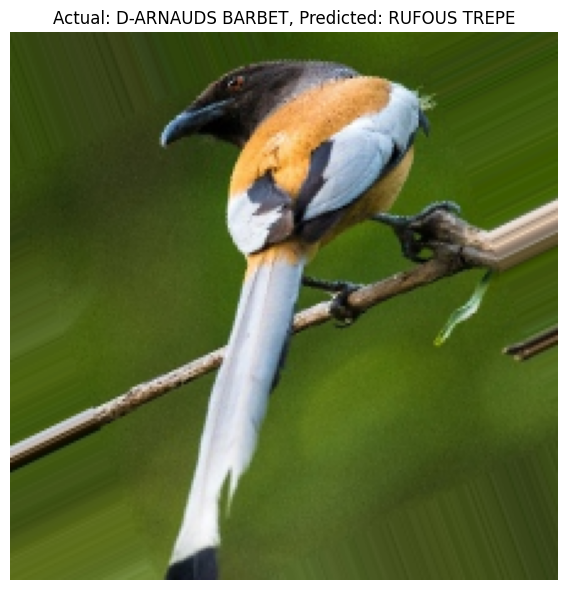

Predicted Probabilities:
D-ARNAUDS BARBET: 0.0000
HOUSE FINCH: 0.0000
RUFOUS TREPE: 1.0000


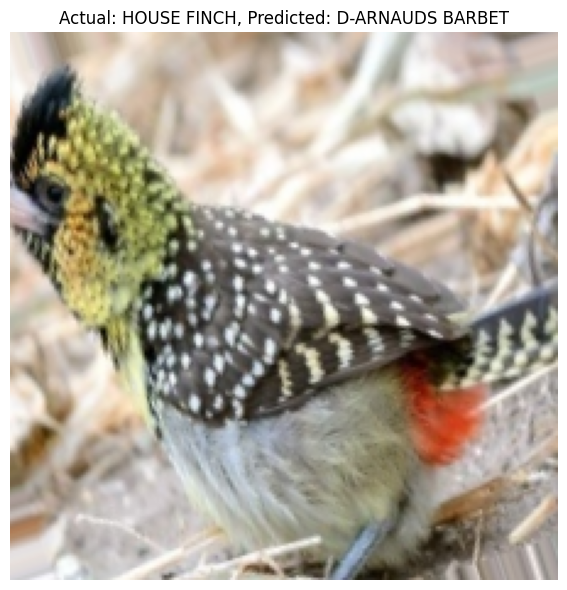

Predicted Probabilities:
D-ARNAUDS BARBET: 1.0000
HOUSE FINCH: 0.0000
RUFOUS TREPE: 0.0000


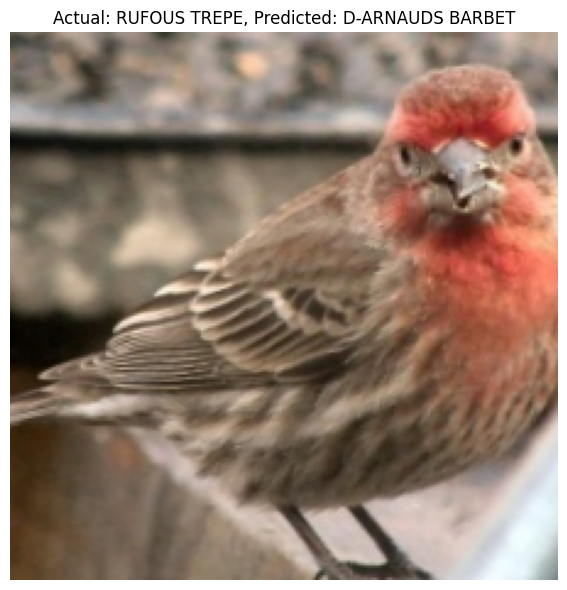

Predicted Probabilities:
D-ARNAUDS BARBET: 1.0000
HOUSE FINCH: 0.0000
RUFOUS TREPE: 0.0000


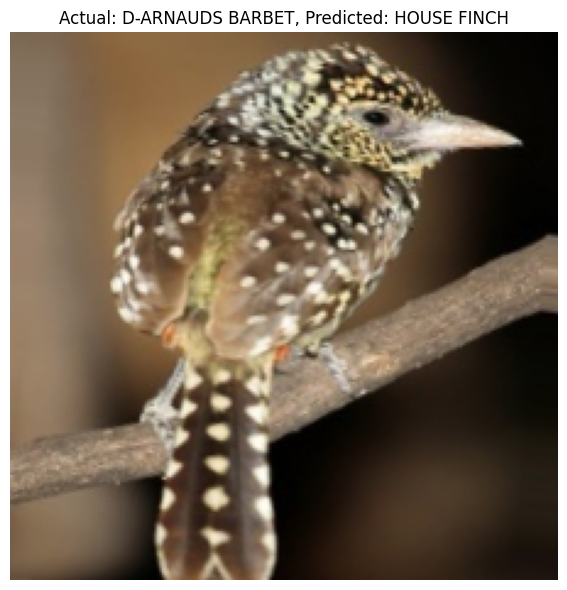

Predicted Probabilities:
D-ARNAUDS BARBET: 0.0000
HOUSE FINCH: 1.0000
RUFOUS TREPE: 0.0000


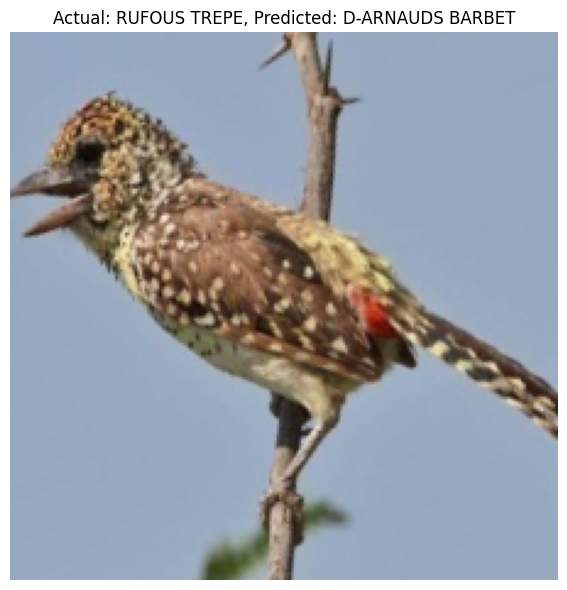

Predicted Probabilities:
D-ARNAUDS BARBET: 1.0000
HOUSE FINCH: 0.0000
RUFOUS TREPE: 0.0000


In [27]:
misclassified_index = np.where(test_predictions_classes != test_labels)[0]

for idx, index in enumerate(misclassified_index):
    # Getting the image batch after that image
    img_batch, _ = test_generator[index // test_generator.batch_size]
    img = img_batch[index % test_generator.batch_size]

    # Getting the true and predicted classes
    true_class_name = class_names[test_labels[index]]
    predicted_class_name = class_names[test_predictions_classes[index]]

    # Getting the predicted probabilities for each class
    predicted_probabilities = test_predictions[index]

    # Displaying the misclassified image
    plt.figure(figsize=(6, 6))
    plt.imshow(img.astype('uint8'))
    plt.title(f'Actual: {true_class_name}, Predicted: {predicted_class_name}', fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Displaying predicted probabilities for each class
    print("Predicted Probabilities:")
    for i, prob in enumerate(predicted_probabilities):
        class_name = class_names[i]
        print(f"{class_name}: {prob:.4f}")

